'''
Goal: Analyze the results of high-throughput sequencing of an EATING library made from E. coli
genomic DNA.

Steps:
1) Load in FASTQ data.
2) Trim out the 3' guide hairpin data and the 5' T7 promoter. 
    - Perhaps analyze these later
    - Idea for most accurate matching: make single-item BLAST database for T7 promoter and for sgRNA hairpin. 
    Get hit locations and use these to trim? Then can also get quality information on hairpin and T7.
    
3) From the 20mer targets:
    - Check percent that map to E. coli genome
    - Percent of mapped 20mers that map next to PAM cutters/at theoretical sites
        - Percent that are MBN trimmed back a base too far.
    - What PAM cutters are underrepresented? 
'''

In [1]:
import os
import Bio 
import re
import timeit
import copy
import sys
from Bio import SeqIO
from Bio.Blast import NCBIXML
from Bio import Restriction 
from Bio.Restriction import *
from Bio.Alphabet.IUPAC import IUPACAmbiguousDNA
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Blast.Applications import NcbiblastnCommandline
from Bio import SeqFeature
from Bio.SeqFeature import *
import pandas
import cPickle as pickle
from numpy import *
from pylab import *
from collections import Counter
import itertools
import operator

In [2]:
len((ecoligenome)[0].seq)

NameError: name 'ecoligenome' is not defined

In [3]:
# Load in the sequencing data. 
reads = []
handle1 = open("hiseqdata/Sample_ADL1_index7/ADL1_all.fastq", 'rb')
record_iter_ADL1 = SeqIO.parse(handle1, "fastq")
handle2 = open("hiseqdata/Sample_ADL_2_index8/ADL2_all.fastq", 'rb')
record_iter_ADL2 = SeqIO.parse(handle2, "fastq")

In [4]:
# a generator that yields items instead of returning a list
def firstn(n, a):
    num = 0
    while num < n:
        yield a.next()
        num += 1

#sum_of_first_n = sum(firstn(1000000))

In [8]:
sgRNAfiltlib5pr_ADL1 = firstn(100, record_iter_ADL1)
sgRNAfiltlib5pr_ADL2 = firstn(40000000, record_iter_ADL2)

In [6]:
# Define the filter that delineates the end of a target 20mer. This uses the first 9nt of the sgRNA hairpin. 
sgRNAconst = SeqRecord(Seq("GTTTAAGAG"))

# Makes a Feature for each of the marker 9nt sgRNA signatures in the FASTQ sequencing files.
def spacersonly(seqs):
    while True:
        seqrecord = seqs.next()
        #for seqrecord in seqs:
        fwdlocs = []  
        revlocs = []  
        fwdlocs = [tloc.start() for tloc in re.finditer(str(sgRNAconst.seq), str(seqrecord.seq))]
        for item in fwdlocs:
            start = ExactPosition(int(item) + 1)
            end = ExactPosition(int((item) + len(sgRNAconst)))
            location = FeatureLocation(start, end)
            feature = SeqFeature(location,type="sgRNAconst", strand = +1)
            seqrecord.features.append(feature)
        revlocs = [tloc.start() for tloc in re.finditer(str(sgRNAconst.reverse_complement().seq), str(seqrecord.seq))]
        for item in revlocs:
            start = ExactPosition(int(item) + 1)
            end = ExactPosition(start + len(sgRNAconst) - 1)
            location = FeatureLocation(start, end)
            feature = SeqFeature(location,type="sgRNAconst", strand = -1)
            seqrecord.features.append(feature)
        for feat in seqrecord.features:
            if feat.strand == 1:
                tgtstart = int(feat.location.start) - 36 # -21
                tgtend = int(feat.location.start) - 1
                sgtgt = seqrecord[tgtstart:tgtend]
                #yield sgtgt
                #alltgts.append(sgtgt)
                #print "pos \n \n"
            if feat.strand == -1:
                tgtend = int(feat.location.end) + 36 # +21
                tgtstart = int(feat.location.end)
                sgtgt = seqrecord[tgtstart:tgtend].reverse_complement()
                sgtgt.name=seqrecord.name
                #yield sgtgt
                #alltgts.append(sgtgt)
            bad = 0
            try:
                l = [tloc.end() for tloc in re.finditer("ACTCACTATAG", str(sgtgt.seq))]
                sgtgt = sgtgt[int(l[0]):]
            except:
                None
            for score in sgtgt.letter_annotations["phred_quality"]:
                if score < 30:
                    bad = 1
            if bad == 0 and len(sgtgt) > 10:
                yield sgtgt
                break
            #except:
                #yield None
            #sys.stdout.flush() # These two lines produce the line counter as the loop runs
            #sys.stdout.write('\r' + str(index) + " "),

First goal: Plot out read abundance vs unique read

In [10]:
#b = spacersonly(sgRNAfiltlib5pr_ADL1)
# c = spacersonly(sgRNAfiltlib5pr_ADL2)
b = spacersonly(itertools.chain(record_iter_ADL1, record_iter_ADL2))

In [ ]:
alltgts = []
for index, item in enumerate(b):
    alltgts.append(item)
    if str(index)[-4:] == "0000": #only print every 10000
        sys.stdout.flush() # These two lines produce the line counter as the loop runs
        sys.stdout.write('\r' + str(index) + " "),

In [12]:
# pickle.dump(alltgts, open("alltgts for ADL1 and ADL2 product of spacersonly.pkl", "wb"))

In [2]:
alltgts = pickle.load(open("alltgts for ADL1 and ADL2 product of spacersonly.pkl", "rb"))

KeyboardInterrupt: (None, <function _reconstructor at 0x100517a28>, (<class 'Bio.SeqRecord._RestrictedDict'>, <type 'dict'>, {'phred_quality': [41, 37, 39, 40, 40, 41, 41, 40, 41, 40, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41]}))

In [ ]:
# Bio.SeqIO.write(alltgts, "HiSeqOut/alltgts_ADL2.fastq", "fastq")

In [2]:
import shelve
import time

In [3]:
alltgts = shelve.open("alltgtsshelf", protocol=2)

In [13]:
# hh = itertools.chain(SeqIO.parse(open("HiSeqOut/alltgts_ADL2.fastq", 'rb'), "fastq"),\
#                      SeqIO.parse(open("HiSeqOut/alltgts_ADL1.fastq", 'rb'), "fastq"))
# i = 0
# for item in hh:
#     alltgts[item.id] = str(item.seq)
#     i = i+1
#     if i == 1000:
#         alltgts.sync()
#         i = 0

In [61]:
item

SeqRecord(seq=Seq('CCATAATGCGGGCGGTTGCC', SingleLetterAlphabet()), id='HS1:391:C5CWBACXX:2:1103:2123:57903', name='HS1:391:C5CWBACXX:2:1103:2123:57903', description='HS1:391:C5CWBACXX:2:1103:2123:57903 1:N:0:ACTTGA', dbxrefs=[])

In [5]:
size(alltgts)

1

This part makes a dict of the reads list, to generate a unique-reads list

In [5]:
tgtsdict = {}
for item in alltgts.values():
    tgtsdict[str(item.seq)] = item

#print len(alltgts)
print len(tgtsdict)

191583


In [6]:
#tgtsdict

Worth plotting the raw spacer distribution *and* the biologically-relevant spacer distribution (i.e. first 20mers)

In [7]:
# Trim alltgts to 20nt; see number of unique spacers:
# This trims non-unique reads list to 
tgts20 = []
for item in alltgts:
    t = item[:20]
    tgts20.append(t)
    
    


KeyboardInterrupt: 

In [137]:
with open('alltgts.csv', 'wb') as tgtswriter:
    a = csv.writer(tgtswriter, delimiter=',')
    for item in alltgts.items():
        a.writerow((item[1],))


In [8]:
# This part makes a dictionary of the first 20mers of each read
tgts20dict = {}
for item in tgts20:
    tgts20dict[str(item.seq)] = item

In [9]:
len(tgts20)

4169111

In [10]:
len(tgts20dict)

163525

In [37]:
stringsonly = (str(item[-20:]) for item in alltgts.values() if len(item) > 10)

In [38]:
c = Counter(stringsonly)

In [ ]:
import operator
sorted_c = sorted(c.items(), key=operator.itemgetter(1))

In [ ]:
x = xrange(0, len(sorted_c))

In [ ]:
counts = []
for item, count in sorted_c:
    counts.append(count)

In [ ]:
len(x)

In [ ]:
import pylab
pylab.plot(x, counts)
pylab.ylim(0, 5000)

In [ ]:
counts[-2]

In [ ]:
bins = []
for b in xrange(2, 48):
    if 2**b < 100000:
        bins.append(2**b)

In [ ]:
% pylab inline
figure()
hist(counts, bins)
gca().set_xscale("log")

This indicates that only a small percentage of unique spacers are present in many copies (>100 copies). However, if that small number of overrepresented spacers makes a large percentage of the library, this could be problematic. Thus we decided to plot the abundance of reads as a total percentage of the library.

In [ ]:
# Percentile-bin the data to show what percent of the library is made up of overrepresented species. This has direct relevance
# to using it in screens. In other words, what percent of the library does the most abundant 0.1% unique reads produce?

In [16]:
stringsonly = (str(item[-20:]) for item in alltgts.values() if len(item) > 10)

In [17]:
sys.path.append("../VirtualEating/")
import al_funcs

Populating the interactive namespace from numpy and matplotlib


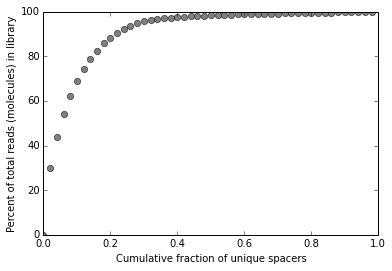

In [18]:
%pylab inline
al_funcs.al_plot_complexity(stringsonly)
#savefig('HiSeqOut/Unique Reads vs Percent of library ADL1.pdf', bbox_inches='tight')

In [20]:
import random

In [117]:
rc = dict(random.sample(c, 10000))

AttributeError: 'builtin_function_or_method' object has no attribute 'sample'

In [124]:
rc = dict(c)

In [34]:
import pandas as pd
from ggplot import *

In [133]:
df = pd.DataFrame({
    "counts": [item[1] for item in rc.items() if item[1] >1],
})
df = pd.melt(df)


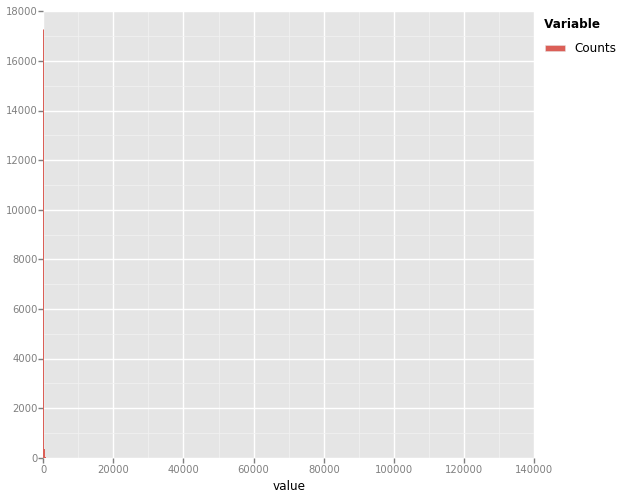

<ggplot: (303110821)>

In [146]:
ggplot(aes(x='value', color='variable'), data=df) + \
    geom_histogram(binwidth = 2)

In [152]:
len(alltgts)

4165908

In [153]:
4165908 /125230 

33

In [6]:
del freqs

NameError: name 'freqs' is not defined

In [8]:
math.log(2,2)

1.0

In [18]:
counts[-50:]

[10.159871336778389,
 10.17492568250068,
 10.216745858195306,
 10.27262978497637,
 10.293471648838134,
 10.321928094887362,
 10.352043425795433,
 10.35974956032233,
 10.382624026574916,
 10.383704292474052,
 10.397674632948268,
 10.417852514885897,
 10.46352437327118,
 10.46454575033394,
 10.492854620174748,
 10.515699838284043,
 10.521600439723727,
 10.52845411076479,
 10.530406337099068,
 10.54978466794786,
 10.595257481449035,
 10.61470984411521,
 10.61470984411521,
 10.615629636968098,
 10.676838606474155,
 10.744833837499547,
 10.758223214726724,
 10.786269627648466,
 10.824163209744158,
 10.874212934830874,
 10.89178370321831,
 10.917372079476841,
 10.95274124718649,
 11.03754695396218,
 11.113090983442381,
 11.172427508645484,
 11.179287104646004,
 11.194141238863136,
 11.234817431117325,
 11.285402218862249,
 11.354800344350597,
 11.459431618637298,
 11.52845411076479,
 11.655530723155643,
 11.775610280759539,
 12.33147682185962,
 12.66177809777199,
 12.987796929042542,
 13.909

In [36]:
c

Counter()

Populating the interactive namespace from numpy and matplotlib


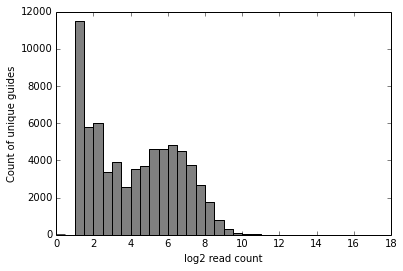

In [40]:
dimport math
mean_guide_copy = len(alltgts) / float(len(c.items()))
import operator
sorted_c = sorted(c.items(), key=operator.itemgetter(1))
counts = []
for item, count in sorted_c:
    if count >1:
#       counts.append(count/mean_guide_copy)
        counts.append(math.log(float(count),2))

# bins = []
# for b in xrange(0, 48):
#     if (2**b)/100.0 < 300000:
#         bins.append((2**b)/100.0)
bins=[x/2.0 for x in (xrange(0, 50, 1))]
% pylab inline
figure()
#gca().set_xscale("log")
# xticks(bins[:], [str(item)[0:5] for item in bins[:]], rotation = -90)
hist(counts, bins[:], color = "gray")
xlabel("log2 read count")
ylabel("Count of unique guides")
savefig('HiSeqOut/Hist for all guides- bothreps.pdf', bbox_inches='tight')

In [114]:
import csv
with open('gcvsabundance.csv', 'wb') as gcwriter:
    a = csv.writer(gcwriter, delimiter=',')
    for item in gcs:
        a.writerow((item[0], item[1], item[2]))


In [33]:
gcs = []
for item, count in c:
    g = float(item.count("G"))
    cn = float(item.count("C"))
    a = float(item.count("A"))
    t = float(item.count("T"))
    gc = (g+cn)*100.0/(g+cn+a+t)
    gcs.append((item, count, gc))

In [ ]:
plot

In [50]:
from ggplot import *

In [51]:
gcsdf = pandas.DataFrame(data=gcs)

In [ ]:
bins = np.logspace(gcsdf[1].min()+1, gcsdf[1].max(), base=2, dtype=list)

In [ ]:
p = ggplot(aes(x=gcsdf[2], y=gcsdf[1]), data=gcsdf)
p+ geom_jitter(alpha=0.05, position="jitter") + scale_y_log10()

Closer analysis revealed that the MmeI enzyme used in trimming genome fragments to 20nt produced a mixture of 20/21nt spacers. We quantified this for all reads (not just unique reads):

In [10]:
lengths = []
for item in alltgts:
    lengths.append(len(item))

In [11]:
list(xrange(0, 10, 1))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import numpy

# This sets my pyplot font to Arial
# http://stackoverflow.com/questions/16574898/how-to-load-ttf-file-in-matplotlib-using-mpl-rcparams?lq=1
path = '/Library/Fonts/Microsoft/Arial.ttf'
prop = fm.FontProperties(fname=path)
mpl.rcParams['font.family'] = prop.get_name()

In [25]:
Counter(lengths)

Counter({21: 2196483, 20: 1880968, 35: 46417, 22: 23942, 19: 10893, 11: 1784, 23: 1666, 24: 1144, 12: 1139, 18: 1094, 14: 875, 13: 792, 17: 753, 16: 738, 15: 390, 25: 9, 28: 8, 26: 5, 27: 4, 31: 3, 29: 2, 36: 2})

Populating the interactive namespace from numpy and matplotlib


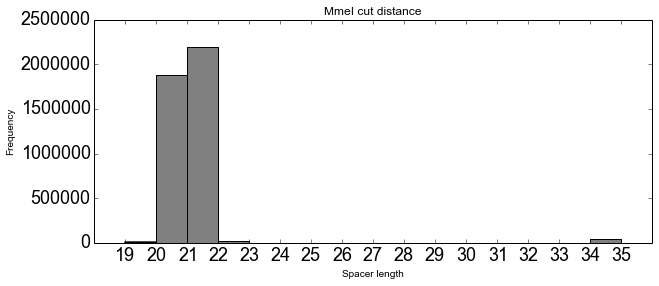

In [30]:
%pylab inline
figure(figsize=(10, 4))
bins = list(xrange(19,36,1))
hist(lengths, bins, color ="gray")
title("MmeI cut distance")
xlabel("Spacer length")
ylabel("Frequency")
#plt.yscale('log')
xticks(list(xrange(19,36,1)))
#plt.yticks( [0, 20, 40,60,80],  [0, 20, 40,60,80] )
#plt.ylim([0,100])
tick_params(axis=u'both', labelsize=18)
savefig('HiSeqOut/MmeI cut distance bothreps.pdf', bbox_inches='tight')

In [68]:
h = open("HiSeqOut/alltgts_ADL2.fastq", "rb")
conv = SeqIO.parse(h, "fastq")

In [69]:
SeqIO.write(conv, "HiSeqOut/alltgts_ADL2.fasta", "fasta")

1906397

In [1]:
#Made a BLAST database from E. coli genome

# To match against the primer BLAST database, which of the mappable 20mers are basically fragment ends?
# First, write out a query fasta containing the mappable targets:
#Bio.SeqIO.write(alltgts, "alltgts.temp", "fasta")

blastn_cline = NcbiblastnCommandline(query="HiSeqOut/alltgts_ADL2.fasta", db="ecolik12", \
task = "blastn-short",outfmt=5, out="HiSeqOut/alltgts_ADL2_more_stringent_eval.blast", max_target_seqs=10, num_threads = 7, evalue = 0.0001, export_search_strategy="alltgts_ADL2_more_stringent_eval.strategy")
#timeit.timeit(blastn_cline, number =1)
blastn_cline()

NameError: name 'NcbiblastnCommandline' is not defined

E value on first run was 0.0001, max_target_seqs was 100. Change to less stringent (0.005)

# This part bins the hits into 4 categories:

    a) Hits in E. coli genome, also hits in predicted cutters (i.e. good)
    b) Hits in E. coli genome, not in predicted cutters (MBN errors)
    c) Short, ambiguous spacers
    d) Longer spacers, but not in E. coli genome

## a) Hits in E. coli genome, also hits in predicted cutters (i.e. good) and
## b) Hits in E. coli genome that aren't predicted cutters (i.e. probably MBN failures)

In [49]:
%run al_funcs.ipynb

In [47]:
handle = open("../../Genomic Data/Escherichia coli str. K-12 substr. MG1655, complete genome.fasta", 'rb')
ecoligenome = [SeqIO.read(handle, "fasta", alphabet=IUPACAmbiguousDNA())]

In [50]:
cutslist = [item for item in al_digesttarget(ecoligenome)]

In [51]:
cutslist[0]

SeqRecord(seq=Seq('GGGACTCGCCGCCGCCCAGC', IUPACAmbiguousDNA()), id='0_F', name='564', description='HpaII', dbxrefs=['gi|545778205|gb|U00096.3|'])

In [20]:
Bio.SeqIO.write(cutslist, "ecoligenomeguides.gb", "gb")

92450

In [53]:
# This gives the number of unique guides expected from the E. coli genome
len(set([str(item.seq) for item in cutslist]))

80894

In [21]:
cutslistdict = {}
for item in cutslist:
    cutslistdict[str(item.seq)] = item.description

In [22]:
cutslistdict['ATGGCGCGCACTACCGCCAC']

'HpaII'

In [23]:
# Load in the BLAST results
result_handle = open("HiSeqOut/alltgts_ADL2.blast")
ecoli_hits_blast = NCBIXML.parse(result_handle) # use NCBIXML.parse(result_handle) for multiple queries here

In [24]:
item = next(ecoli_hits_blast)

In [26]:
item.alignments[0].hsps[0].query[0:20]

u'CGAGCAGGGTTTTCAACGCA'

In [39]:
a_goodguides = []
b_MBNerrors = []
c_15match_guides = []
whittlinglist = []

# IF: a blast entry has a score of >20 and is in the theoretical guides list, put into a_guideslist.
# ELSEIF: a blast entry has a score of >20 but isn't in the guides list, put into b_MBNerrors.
    
# Otherwise, put into a list to be dealt with and meted out later.
index = 0

for item in range(100000):
    try:
        item = next(ecoli_hits_blast)
    except:
        break
    index += 1
    try:
        if item.alignments[0].hsps[0].score > 19:
            try: 
                a_goodguides.append((cutslistdict[item.alignments[0].hsps[0].query[0:20]], item.alignments[0].hsps[0].query[0:20]))
            except:
                b_MBNerrors.append(item)
        elif item.alignments[0].hsps[0].score > 14:
            c_15match_guides.append(item)
        else:
            whittlinglist.append(item)
    except:
        whittlinglist.append(item)
    if str(index)[-5:] == "00000": #only print every 100000
        sys.stdout.flush() # These two lines produce the line counter as the loop runs
        sys.stdout.write('\r' + str(index) + " "),

100000 

In [25]:
#def carveup(item):
    

In [26]:
index

1906397

In [27]:
len(a_goodguides)

885983

In [28]:
len(b_MBNerrors)

900331

In [29]:
len(c_15match_guides)

0

In [30]:
len(whittlinglist)

120083

In [31]:
pickle.dump(a_goodguides, open( "HiSeqOut/a_goodguides_ADL2_more_stringent.p", "wb" ))
pickle.dump(b_MBNerrors, open( "HiSeqOut/b_MBNerrors_ADL2_more_stringent.p", "wb" ))
pickle.dump(c_15match_guides, open( "HiSeqOut/c_15match_guides_ADL2_more_stringent.p", "wb" ))
pickle.dump(whittlinglist, open( "HiSeqOut/whittlinglist_ADL2_more_stringent.p", "wb" ))

#favorite_color = pickle.load( open( "save.p", "rb" ) )
#del a_goodguides
#del b_MBNerrors

In [35]:
a_goodguides = pickle.load( open( "HiSeqOut/a_goodguides_ADL2_more_stringent.p", "r"))

In [39]:
a_goodguides_1 = pickle.load( open( "HiSeqOut/a_goodguides_ADL1_more_stringent.p", "r"))

In [42]:
print len(a_goodguides) # This is the number of good guides in ADL2
print len(a_goodguides_1) # This is the number of good guides in ADL1
print len(set(a_goodguides))
print len(set(a_goodguides_1))

885983
1003280
37854
38774


In [ ]:
)

In [43]:
a_goodguides_bothreps = a_goodguides
a_goodguides_bothreps.extend(a_goodguides_1)

In [44]:
len(set(a_goodguides_bothreps))

41638

In [6]:
b_MBNerrors = pickle.load( open( "HiSeqOut/b_MBNerrors_ADL2_more_stringent.p", "r"))

In [7]:
b_MBNerrors_1 = pickle.load( open( "HiSeqOut/b_MBNerrors_Ab_MBNerrors_more_stringent.p", "r"))

In [9]:
len(b_MBNerrors_1)

1037184

In [25]:
b_MBNerrors[11].query_letters

20

In [28]:
from collections import Counter

In [38]:
Counter([len(sequence) for enz, sequence in a_goodguides[:1000]])

Counter({20: 1000})

In [34]:
Counter([l.query_length for l in b_MBNerrors_1[0:200000]])

Counter({21: 187416, 20: 5887, 35: 4905, 22: 1659, 24: 66, 23: 65, 27: 2})

In [56]:
b_MBNerrors_bothreps = b_MBNerrors
b_MBNerrors_bothreps.extend(b_MBNerrors_1)

In [57]:
len(set([item.alignments[0].hsps[0].query for item in b_MBNerrors_bothreps]))

83823

In [58]:
len(set([item.alignments[0].hsps[0].query[0:20] for item in b_MBNerrors_bothreps]))

67378

### Result:
| Experiment  | E value      | Category | Count  |
| ------------|--------------|----------| -------|
| ADL1        | 0.0001?      | Total    |2,262,713 |
|             |              | A: good    |1,003,277 |
|             |              | B: MBN error    |1,037,187 |
| | | Others? | 222,250
| ADL1        | 0.005?      | Total    |2,262,713 |
|             |              | A: good    |1,003,277 |
|             |              | B: MBN error    |1,037,187 |
| | | C: 15-matches | 22,370
| | | Others? | 199,880
| **ADL2**        | **0.005?**      | **Total**    |**1906396** |
|             |              | A: good    |885981 |
|             |              | B: MBN error    |900333 |
| | | C: 15-matches |19354
| | | Others? | 199,880


In [40]:
handle = open("HiSeqOut/alltgts_ADL1.fastq", 'rb')
ADL1 = SeqIO.parse(handle, "fastq")

In [41]:
#next(ADL1)

In [42]:
ADL1_dict = {}
for item in ADL1:
    ADL1_dict[str(item.description)] = item

### What's in the "remainders" list (short reads, other organisms' reads...)

In [43]:
whittlinglist_with_data = []

for item in whittlinglist:
    whittlinglist_with_data.append((ADL1_dict[item.query], item))

In [44]:
lengths = []
for item, blast in whittlinglist_with_data:
    lengths.append(len(item))

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


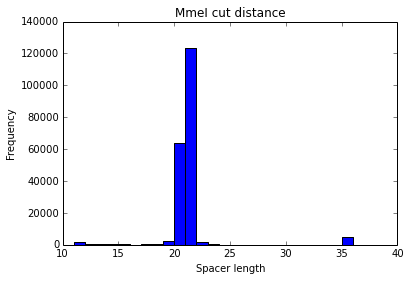

In [45]:
%pylab inline
figure()
bins = list(xrange(0,37,1))
hist(lengths, bins)
title("MmeI cut distance")
xlabel("Spacer length")
ylabel("Frequency")
#plt.yscale('log')
#xticks([18, 19, 20,21,22, 23, 24, 25, 26])
#plt.yticks( [0, 20, 40,60,80],  [0, 20, 40,60,80] )
#plt.ylim([0,100])
savefig('HiSeqOut/MmeI cut distance for non E coli ADL1.pdf', bbox_inches='tight')

In [ ]:
#### The spacer length in the remainders list looks pretty normal. What about the BLAST properties? How many are just 1-2 nt mismatches?

In [46]:
nearmatch = 0
noalignments = 0

for item in whittlinglist_with_data:
    try:
        if item[1].alignments[0].hsps[0].score > 15:
            nearmatch += 1
    except:
        noalignments += 1


In [47]:
print(nearmatch)

0


In [48]:
print(noalignments)

199880


In [49]:
hitlengths = []
for item, blast in whittlinglist_with_data:
    hitlengths.append(len(blast.alignments))

In [50]:
len(whittlinglist_with_data)

199880

In [40]:
stringsonly = []
for cut, item in a_goodguides:
    stringsonly.append(str(item[0:20]))

Populating the interactive namespace from numpy and matplotlib


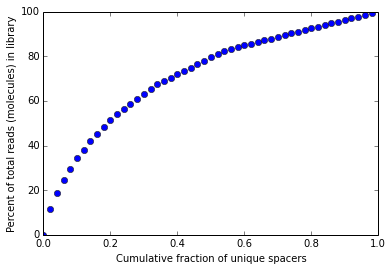

In [41]:
al_plot_complexity(stringsonly)
savefig('HiSeqOut/Unique Reads vs Percent of library ADL2_ForGoodGuidesOnly_more_stringent_eval_100000_only.pdf', bbox_inches='tight')

Populating the interactive namespace from numpy and matplotlib


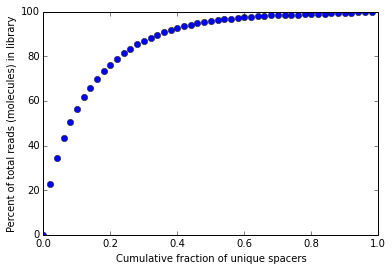

In [34]:
stringsonly = []
for item in b_MBNerrors:
    stringsonly.append(str(item.alignments[0].hsps[0].query[0:20]))
al_plot_complexity(stringsonly)
savefig('HiSeqOut/Unique Reads vs Percent of library ADL2_b_MBNerrors_more_stringent_eval.pdf', bbox_inches='tight')

In [62]:
item

Populating the interactive namespace from numpy and matplotlib


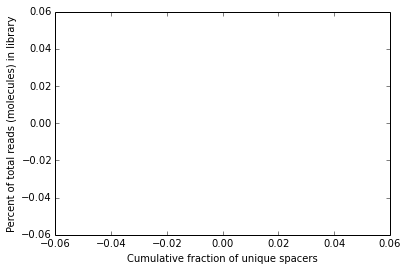

In [20]:
stringsonly = []
for item in c_15match_guides:
    stringsonly.append(str(item.alignments[0].hsps[0].query[0:20]))
al_plot_complexity(stringsonly)
savefig('HiSeqOut/Unique Reads vs Percent of library ADL2_c_15match_guides_more_stringent_eval.pdf', bbox_inches='tight')

In [ ]:
whittlinglist[0]

In [21]:
stringsonly = []
for cut, item in whittlinglist:
    stringsonly.append(str(item.alignments[0].hsps[0].query[0:20]))
al_plot_complexity(stringsonly)
savefig('HiSeqOut/Unique Reads vs Percent of library ADL1_whittlinglist_more_stringent_eval.pdf', bbox_inches='tight')

TypeError: 'Blast' object is not iterable

Next to the total "spacer" list, the good guides are somewhat more linearly distributed with
respect to their representationin the guides list. 

**Go back and plot a histogram of representation for the good guides only:**

In [18]:
a_goodguides_ADL2 = pickle.load( open( "HiSeqOut/a_goodguides_ADL2_more_stringent.p", "rb" ) )

In [11]:
a_goodguides_ADL1 = pickle.load( open( "HiSeqOut/a_goodguides_ADL1_more_stringent.p", "rb" ) )

In [19]:
len(a_goodguides_ADL2)

885983

In [59]:
alltgts = a_goodguides_bothreps

In [60]:
alltgts[0]

('HpaII', u'ATAGCGGTTAAAACCTTCAC')

In [61]:
# Trim alltgts to 20nt; see number of unique spacers:
# This trims non-unique reads list to 
tgts20 = []
for item in alltgts:
    t = item[1][:20]
    tgts20.append(t)
from collections import Counter
c = Counter(tgts20)

In [62]:
len(c)

41638

In [66]:
freqs = []
mean_guide_copy = len(a_goodguides_bothreps) / float(len(c))
for item in c:
   freqs.append((c[item], c))
import operator
sorted_c = sorted(c.items(), key=operator.itemgetter(1))
counts = []
for item, count in sorted_c:
    counts.append(count/mean_guide_copy)
bins = []
for b in xrange(0, 48):
    if (2**b)/100.0 < 3000:
        bins.append((2**b)/100.0)
bins = [0.015625,0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8,16,32,64,128,256]
#for b in xrange(1, 48, 1):
    #if (1.2**b)/100 < 150:
        #bins.append((1.2**b)/100)

Populating the interactive namespace from numpy and matplotlib


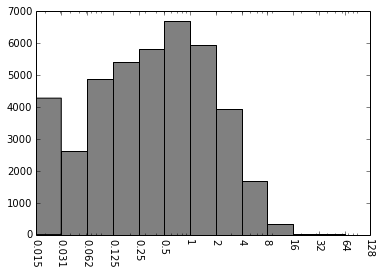

In [67]:
% pylab inline
figure()
gca().set_xscale("log")
#gca().set_yscale("log")
xticks(bins[:], [str(item)[0:5] for item in bins[:]], rotation = -90)
hist(counts, bins[:], color = "gray")
savefig('HiSeqOut/Good Guides Count for unique instances bothreps LogLog (more_stringent_eval).pdf', bbox_inches='tight')

In [128]:
sorted_c[0]

(u'GCCAATACGGTCGAGAAAAC', 1)

In [119]:
bins

[0.01,
 0.02,
 0.04,
 0.08,
 0.16,
 0.32,
 0.64,
 1.28,
 2.56,
 5.12,
 10.24,
 20.48,
 40.96,
 81.92,
 163.84,
 327.68,
 655.36,
 1310.72,
 2621.44]

In [43]:
min(counts)

0.04272542475419957

In [25]:
# This gives the mean copies of guides (total good reads divided by total unique reads)
mean_guide_copy = len(a_goodguides_ADL2) / float(len(c))

In [26]:
# This gives the standard deviation of copies of guides
std_guide_copy = std([b for a, b in c.items()])

In [27]:
# The percent of guides within 2 standard deviations
float(len([count for seq, count in c.items() if count < (mean_guide_copy + 2*std_guide_copy)])) / len(c) * 100

96.05061552279813

In [28]:
len(c.items())

37854

(array([  0.00000000e+00,   5.07900000e+03,   5.35200000e+03,
          5.93300000e+03,   6.57100000e+03,   6.50000000e+03,
          4.96200000e+03,   2.55800000e+03,   7.81000000e+02,
          1.03000000e+02,   1.20000000e+01,   3.00000000e+00]),
 array([   0,    1,    2,    4,    8,   16,   32,   64,  128,  256,  512,
        1024, 2048]),
 <a list of 12 Patch objects>)

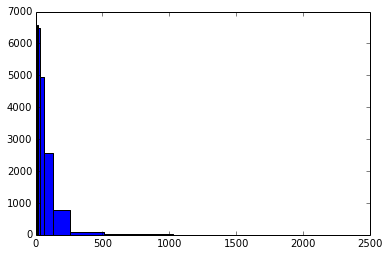

In [11]:
hist(counts, bins)


In [12]:
sorted_c[0]

(u'GCCAATACGGTCGAGAAAAC', 1)

In [13]:
from pandas import *

In [14]:
df = DataFrame(sorted_c)

In [15]:
import csv
with open('sorted_c.csv', 'wb') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    for item in sorted_c:
        spamwriter.writerow(item)

In [32]:
df

,0,1
0,GCCAATACGGTCGAGAAAAC,1
1,GATGTAATAATCCAGTTGCC,1
2,AGGCTTGATCGAGATACCGC,1
3,GTAGCGACCGATACATTACC,1
4,AATGTTATTTGCTACTGTCC,1
5,CATCGCAGCCCTGAAAACGC,1
6,CGTGACTGAACTGATGATGC,1
7,TTCGCGCCGGCGTGTACACC,1
8,GTTATCAAGAACATAGATAC,1
9,TAGAGATCATAATGATCGCC,1


In [32]:
df

,0,1
0,GCCAATACGGTCGAGAAAAC,1
1,GATGTAATAATCCAGTTGCC,1
2,AGGCTTGATCGAGATACCGC,1
3,GTAGCGACCGATACATTACC,1
4,AATGTTATTTGCTACTGTCC,1
5,CATCGCAGCCCTGAAAACGC,1
6,CGTGACTGAACTGATGATGC,1
7,TTCGCGCCGGCGTGTACACC,1
8,GTTATCAAGAACATAGATAC,1
9,TAGAGATCATAATGATCGCC,1


In [24]:
from ggplot import *

In [42]:
df[1]

0     1
1     1
2     1
3     1
4     1
5     1
6     1
7     1
8     1
9     1
10    1
11    1
12    1
13    1
14    1
...
37839     514
37840     520
37841     535
37842     539
37843     599
37844     629
37845     632
37846     695
37847     702
37848     728
37849     741
37850     805
37851    1054
37852    1374
37853    1474
Name: 1, Length: 37854, dtype: int64

In [84]:
DataFrame(bins)

,0
0,0
1,1
2,2
3,4
4,8
5,16
6,32
7,64
8,128
9,256


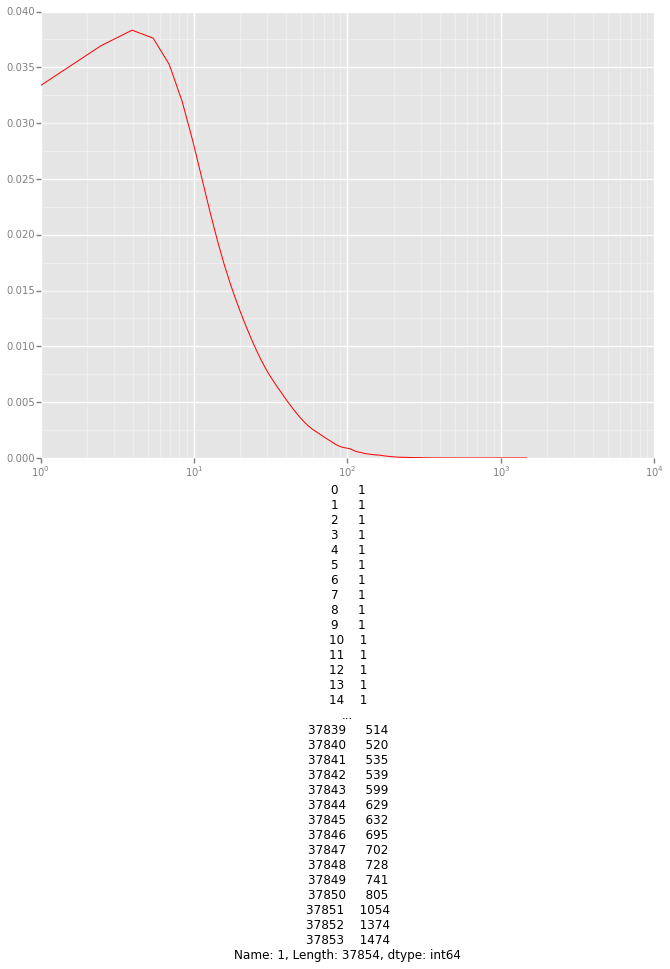

<ggplot: (314387005)>

In [94]:
ggplot(df, aes(x=df[1]))  + \
    scale_x_log10()+ \
    geom_density(alpha=1, kernel="optcosine", adjust = 0.1, color= "red")

In [1]:
%load_ext rmagic

In [7]:
import scipy
import pylab
import numpy
from numpy import *
import rpy2
from rpy2 import *
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [8]:
import rpy2.robjects.lib.ggplot2 as ggplot2
import rpy2.robjects as ro
from rpy2.robjects.packages import importr

datasets = importr('datasets')
#mtcars = datasets.mtcars
mtcars = datasets.__rdata__.fetch('mtcars')['mtcars']

In [9]:
rnorm = stats.rnorm
dataf_rnorm = robjects.DataFrame({'value': rnorm(300, mean=0) + rnorm(100, mean=3),
                                  'other_value': rnorm(300, mean=0) + rnorm(100, mean=3),
                                  'mean': robjects.IntVector([0, ]*300 + [3, ] * 100)})

NameError: name 'stats' is not defined

In [10]:
gp = ggplot2.ggplot(mtcars)

In [11]:
pp = gp + \
     ggplot2.aes_string(x='wt', y='mpg') + \
     ggplot2.geom_point()

pp.plot()

-----------

-----------

-----------

In [ ]:
featured_genome = SeqRecord(ecoligenome.seq)
from Bio import SeqUtils
from Bio.SeqUtils import *
import sys

for index, item in enumerate(bummerguidesseq):
    if len(item.seq) > 0:
        # setup toolbar
        #sys.stdout.flush() # These two lines produce the line counter as the loop runs
        #sys.stdout.write('\r' + str(index) + " "),
        featinfo = []
        fwd = nt_search(str(featured_genome.seq), str(item.seq))
        if len(fwd) > 1:
            featinfo.append((fwd, +1))
        rev = nt_search(str(featured_genome.seq), str(item.seq.reverse_complement()))
        if len(rev) > 1:
            featinfo.append((rev, -1))
        for f in featinfo:
            start = ExactPosition(f[0][1])
            end = ExactPosition(f[0][1] + len(item.seq))
            location = FeatureLocation(start, end)
            feature = SeqFeature(location,type=str("spacer"), strand = f[1])
            featured_genome.features.append(feature)     
# The output seq below is derived from the genomic search result, not the input

In [ ]:
SeqIO.write(featured_genome, "bummerguides.gb", "gb")

In [79]:
print float(len(featured_genome.features))/len(alltgts)
print len(featured_genome.features)

0.924512387981
8769


In [36]:
handle = open("../../Genomic Data/Escherichia coli str. K-12 substr. MG1655, complete genome.fasta", 'rb')
ecoligenome = SeqIO.parse(handle, "fasta", alphabet=IUPACAmbiguousDNA())
ecoligenomedict = {}
ecoligenomedict["gi|545778205|gb|U00096.3| Escherichia coli str. K-12 substr. MG1655, complete genome"] = next(ecoligenome)

In [37]:
%run al_funcs.ipynb

In [38]:
for index, item in enumerate(cutslist[68:69]):
    summary = al_scoreguide(item, "ecolik12", ecoligenomedict)
    score, details = summary
    print score
    print zip([b[1][2] for b in details], [b[1][1] for b in details])

ValueError: too many values to unpack

In [39]:
len(cutslist)

92450

In [40]:
(item for item in cutslist[68:69])

<generator object <genexpr> at 0x123d4ca50>

In [41]:
al_scoreguide(cutslist[68], "ecolik12", ecoligenomedict)

(100,
 SeqRecord(seq=Seq('CGGGTAACAATC', IUPACAmbiguousDNA()), id='34_F', name='5534', description='HpaII', dbxrefs=['gi|545778205|gb|U00096.3|']),
 [[0.0,
   (u'gi|545778205|gb|U00096.3| Escherichia coli str. K-12 substr. MG1655, complete genome',
    2458718,
    u'CGGGTAACAATC')],
  [0.0,
   (u'gi|545778205|gb|U00096.3| Escherichia coli str. K-12 substr. MG1655, complete genome',
    3198029,
    u'CGGGTAACAATC')],
  [0.0,
   (u'gi|545778205|gb|U00096.3| Escherichia coli str. K-12 substr. MG1655, complete genome',
    686730,
    u'GGGTAACAATC')],
  [0.0,
   (u'gi|545778205|gb|U00096.3| Escherichia coli str. K-12 substr. MG1655, complete genome',
    4467035,
    u'CGGGTAACAAT')],
  [0.0,
   (u'gi|545778205|gb|U00096.3| Escherichia coli str. K-12 substr. MG1655, complete genome',
    16360,
    u'GGTAACAATC')],
  [0.0,
   (u'gi|545778205|gb|U00096.3| Escherichia coli str. K-12 substr. MG1655, complete genome',
    58981,
    u'GGTAACAATC')],
  [0.0,
   (u'gi|545778205|gb|U00096.3| E

In [42]:
cutslist[0]

SeqRecord(seq=Seq('GGGACTCGCCGCCGCCCAGC', IUPACAmbiguousDNA()), id='0_F', name='564', description='HpaII', dbxrefs=['gi|545778205|gb|U00096.3|'])

In [ ]:
all_ecoli_scores = []
for index, item in enumerate(cutslist):
    if str(index)[-3:] == "000":
        print index
    all_ecoli_scores.append([al_scoreguide(item, "ecolik12", ecoligenomedict), item])

In [47]:
pickle.dump(all_ecoli_scores, open( "HiSeqOut/Part 5 - functional mapping/all_ecoli_guidescores.p", "wb" ))

In [2]:
import cPickle as pickle

In [3]:
all_ecoli_scores = pickle.load(open( "HiSeqOut/Part 5 - functional mapping/all_ecoli_guidescores.p", "r" ))

In [4]:
import copy
a = []
for (score, details) in all_ecoli_scores:
    a.append(int(details.name))
resultssorted = zip([[r[0], b] for r, b in all_ecoli_scores], a)
from operator import itemgetter, attrgetter, methodcaller
resultssorted = sorted(resultssorted, key=itemgetter(0), reverse=True)
resultssorted = [item for item, bullshit in resultssorted]

In [21]:
set([score, str(details.seq) in resultssorted])

[100,
 SeqRecord(seq=Seq('CTCGTTGCTCTAAAAGCCCC', IUPACAmbiguousDNA()), id='46227_R', name='4641552', description='ScrFI', dbxrefs=['gi|545778205|gb|U00096.3|'])]

Populating the interactive namespace from numpy and matplotlib


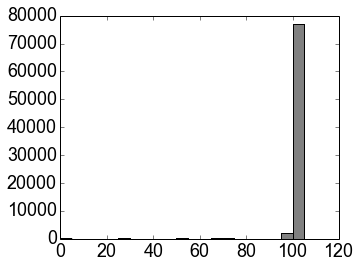

In [31]:
# The set stuff here collapses redundant guides
scores = [score for score, details in set([(score, str(details.seq)) for score, details in resultssorted])]
import numpy
bins = range(0,106, 5)
% pylab inline
figure(figsize=(5, 4))
hist(scores, bins, color="gray")
tick_params(axis=u'both', labelsize=18)
(n, bins, patches) = plt.hist(scores, bins, color="gray")
savefig('HiSeqOut/All_Ecoli_guide_scores_redundancy_removed.pdf', format="pdf")
#gca().set_xscale("log")

In [34]:
len(scores)

80894

In [32]:
print zip(n, bins)

[(45.0, 0), (16.0, 5), (13.0, 10), (38.0, 15), (23.0, 20), (170.0, 25), (53.0, 30), (20.0, 35), (64.0, 40), (64.0, 45), (193.0, 50), (38.0, 55), (67.0, 60), (311.0, 65), (423.0, 70), (37.0, 75), (8.0, 80), (45.0, 85), (55.0, 90), (2136.0, 95), (77075.0, 100)]


In [23]:
import collections

In [33]:
collections.Counter(scores)

NameError: name 'collections' is not defined

In [36]:
for number, count in collections.Counter(scores).items():
    print((number, count*100.0/92450.0))

(0, 0.05300162249864792)
(1, 0.19578150351541374)
(2, 0.015143320713899405)
(3, 0.011898323418063819)
(4, 0.005408328826392645)
(5, 0.0075716603569497025)
(6, 0.001081665765278529)
(7, 0.011898323418063819)
(8, 0.005408328826392645)
(9, 0.012979989183342347)
(10, 0.001081665765278529)
(11, 0.002163331530557058)
(12, 0.001081665765278529)
(13, 0.005408328826392645)
(14, 0.029204975662520283)
(15, 0.0746349378042185)
(16, 0.16982152514872903)
(17, 0.016224986479177934)
(19, 0.015143320713899405)
(20, 0.009734991887506761)
(21, 0.014061654948620876)
(22, 0.017306652244456464)
(23, 0.008653326122228232)
(24, 0.0411032990805841)
(25, 1.040562466197945)
(26, 0.006489994591671174)
(27, 0.015143320713899405)
(28, 0.19686316928069228)
(29, 0.006489994591671174)
(30, 0.012979989183342347)
(32, 0.014061654948620876)
(33, 0.20118983234180637)
(34, 0.004326663061114116)
(35, 0.001081665765278529)
(36, 0.002163331530557058)
(37, 0.006489994591671174)
(38, 0.008653326122228232)
(39, 0.041103299080584

In [34]:
collections.Counter(scores).items()

[(0, 49),
 (1, 181),
 (2, 14),
 (3, 11),
 (4, 5),
 (5, 7),
 (6, 1),
 (7, 11),
 (8, 5),
 (9, 12),
 (10, 1),
 (11, 2),
 (12, 1),
 (13, 5),
 (14, 27),
 (15, 69),
 (16, 157),
 (17, 15),
 (19, 14),
 (20, 9),
 (21, 13),
 (22, 16),
 (23, 8),
 (24, 38),
 (25, 962),
 (26, 6),
 (27, 14),
 (28, 182),
 (29, 6),
 (30, 12),
 (32, 13),
 (33, 186),
 (34, 4),
 (35, 1),
 (36, 2),
 (37, 6),
 (38, 8),
 (39, 38),
 (40, 166),
 (41, 6),
 (42, 7),
 (43, 6),
 (44, 18),
 (45, 21),
 (46, 17),
 (47, 25),
 (48, 17),
 (49, 44),
 (50, 461),
 (51, 8),
 (52, 20),
 (53, 4),
 (54, 9),
 (55, 8),
 (56, 4),
 (57, 4),
 (58, 4),
 (59, 23),
 (60, 10),
 (61, 9),
 (62, 26),
 (63, 8),
 (64, 32),
 (65, 32),
 (66, 554),
 (67, 22),
 (69, 6),
 (70, 421),
 (71, 1),
 (72, 11),
 (73, 1),
 (74, 2),
 (77, 8),
 (78, 26),
 (79, 3),
 (80, 2),
 (81, 1),
 (83, 3),
 (84, 2),
 (85, 16),
 (86, 4),
 (87, 26),
 (88, 2),
 (89, 2),
 (90, 8),
 (91, 3),
 (92, 5),
 (93, 18),
 (94, 25),
 (95, 91),
 (96, 69),
 (97, 158),
 (98, 296),
 (99, 1657),
 (100, 8